In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Векторизируем сгенерированные изображения. Будем сжимать их до размера (200, 200) и чернобелого цвета:

In [2]:
os.chdir('dataset_false')
for i in os.listdir():
    img = Image.open(i)
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if i != 'im0.png':
        data_false = np.append(data_false, sums, axis=0)
    else:
        data_false = np.array(sums)
os.chdir('..')

In [3]:
data_false.shape

(4999, 200, 200)

In [4]:
os.chdir('dataset_true')
for i in os.listdir():
    img = Image.open(i)
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if i != '0.png':
        data_true = np.append(data_true, sums, axis=0)
    else:
        data_true = np.array(sums)
os.chdir('..')

In [5]:
data_true.shape

(5000, 200, 200)

In [14]:
os.chdir('test_true')
first = False
for i in os.listdir():
    img = Image.open(i)
    img = img.convert('RGB')
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if first:
        test_true = np.append(test_true, sums, axis=0)
    else:
        first = True
        test_true = np.array(sums)
os.chdir('..')

In [16]:
test_true.shape

(173, 200, 200)

In [17]:
os.chdir('test_false_hard')
first = False
for i in os.listdir():
    img = Image.open(i)
    img = img.convert('RGB')
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if first:
        test_hard_false = np.append(test_hard_false, sums, axis=0)
    else:
        first = True
        test_hard_false = np.array(sums)
os.chdir('..')

In [18]:
test_hard_false.shape

(42, 200, 200)

In [19]:
os.chdir('test_false_easy')
first = False
for i in os.listdir():
    img = Image.open(i)
    img = img.convert('RGB')
    img = img.resize((200, 200))
    arr = np.asarray(img, dtype='uint8')
    k = np.array([[[0.2989, 0.587, 0.114]]])
    sums = np.round(np.sum(arr*k, axis=2)).astype(np.uint8)
    sums = sums.reshape((1, 200, 200))
    if first:
        test_easy_false = np.append(test_easy_false, sums, axis=0)
    else:
        first = True
        test_easy_false = np.array(sums)
os.chdir('..')

In [20]:
test_easy_false.shape

(80, 200, 200)

# Смёрджим, разметим и перемешаем данные:

In [21]:
data_x_train = np.concatenate((data_false, data_true))
data_y_train = np.concatenate((np.zeros(4999), np.ones(5000))).astype('int32')
data_x_test = np.concatenate((test_true, test_hard_false, test_easy_false))
data_y_test = np.concatenate((np.ones(test_true.shape[0]), np.zeros(test_hard_false.shape[0] + test_easy_false.shape[0]))).astype('int32')

In [22]:
all_data_train = np.concatenate((data_x_train.reshape(9999, 40000), data_y_train.reshape(9999, 1)), axis=1)
all_data_test = np.concatenate((data_x_test.reshape(data_x_test.shape[0], 40000), 
                                data_y_test.reshape(data_y_test.shape[0], 1)), axis=1)

In [23]:
np.random.shuffle(all_data_train)
np.random.shuffle(all_data_test)

In [24]:
data_x_train = all_data_train[:, :-1].reshape(9999, 200, 200)
data_y_train = all_data_train[:, -1]
data_x_test = all_data_test[:, :-1].reshape(data_x_test.shape[0], 200, 200)
data_y_test = all_data_test[:, -1]

In [25]:
data_x_train.shape

(9999, 200, 200)

In [26]:
data_x_test.shape

(295, 200, 200)

# Модель:

In [30]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0001), metrics=['binary_accuracy'])

# Будем обучать модель на сгенерированных данных, а тестировать на собранных реальных.
# Обучение:

In [34]:
history = model.fit(data_x_train, data_y_train, epochs=25, validation_data=(data_x_test, data_y_test), batch_size=512)

Epoch 1/25
20/20 [==============================] - 933s 47s/step - loss: 9.3558 - binary_accuracy: 0.7768 - val_loss: 0.7005 - val_binary_accuracy: 0.8847
Epoch 2/25
20/20 [==============================] - 1061s 53s/step - loss: 1.5448 - binary_accuracy: 0.8432 - val_loss: 0.2971 - val_binary_accuracy: 0.9153
Epoch 3/25
20/20 [==============================] - 1034s 52s/step - loss: 0.0832 - binary_accuracy: 0.9720 - val_loss: 1.7109 - val_binary_accuracy: 0.8102
Epoch 4/25
20/20 [==============================] - 1079s 54s/step - loss: 0.0606 - binary_accuracy: 0.9852 - val_loss: 0.3004 - val_binary_accuracy: 0.9322
Epoch 5/25
20/20 [==============================] - 1102s 55s/step - loss: 1.2744 - binary_accuracy: 0.9097 - val_loss: 0.2058 - val_binary_accuracy: 0.9220
Epoch 6/25
20/20 [==============================] - 1111s 55s/step - loss: 0.0395 - binary_accuracy: 0.9872 - val_loss: 0.1866 - val_binary_accuracy: 0.9356
Epoch 7/25
20/20 [==============================] - 1087s 5

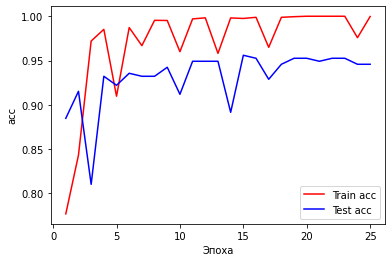

In [39]:
plt.plot(range(1, 26), history.history['binary_accuracy'], 'b', c='red', label='Train acc')
plt.plot(range(1, 26), history.history['val_binary_accuracy'], 'b', label='Test acc')
plt.xlabel('Эпоха')
plt.ylabel('acc')
plt.legend()
plt.show()

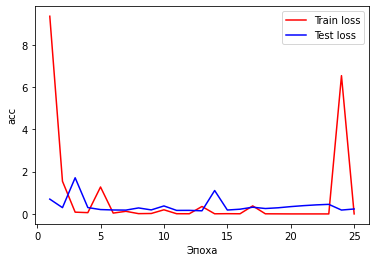

In [41]:
plt.plot(range(1, 26), history.history['loss'], 'b', c='red', label='Train loss')
plt.plot(range(1, 26), history.history['val_loss'], 'b', label='Test loss')
plt.xlabel('Эпоха')
plt.ylabel('acc')
plt.legend()
plt.show()

# Скорее всего более высокая точность не достигается из-за однообразия сгенерированных изображений. Попробуем расширить датасет.